<h2 align="center"> Importing all the required libraries </h2>



*   Here our dataset is the brown corpus dataset 



In [21]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown
import numpy as np
# Importing the required libraries
from sklearn.metrics import confusion_matrix,precision_score, recall_score
import seaborn as sns
import pandas as pd

tagged_sentences = list(brown.tagged_sents(tagset = 'universal'))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


<h2 align="center"> POS tagger </h2>

<ul>
<li> The POS tagger class is initliazed with the tagged sentence as it's parameter  </li>
<li> It has attributes such as tag_given_word and word_given_tag which are the respective conditional probabilities </li>
<li> Finally, it also has the implementation of the viterbi algorithm within itself </li>
</ul>

In [22]:
class POS_Tagger_HMM:
  def __init__(self, tagged_sentences_orignal):
    
    punct = ['``','!','"','#','$','%','&',"'",'(',')','*','+',',','-','/',':',';','<','=','>','?', '@','[','\\',']','_','`','{','|','}','~',"''",'""']
    tagged_sentences = tagged_sentences_orignal
    for tagged_sentence in tagged_sentences:
        tagged_sentence.insert(0, ('^', '^'))
        for i in range(len(tagged_sentence)):
            word, tag = tagged_sentence[i]
            word = word.lower()
            if word in punct:
                tag = 'PUNCT'
                tagged_sentence[i] = (word, tag)
            else:
                tagged_sentence[i] = (word, tag)
            
    self.tagged_sentences = tagged_sentences
    self.unique_words, self.unique_tags = [], []

    for tagged_sentence in self.tagged_sentences:
      for word, tag in tagged_sentence:
        if word not in self.unique_words:
          self.unique_words.append(word)

        if tag not in self.unique_tags:
          self.unique_tags.append(tag)
    
    self.tag_given_word = {word : {tag : 0 for tag in self.unique_tags} for word in self.unique_words}
    self.word_given_tag = {tag : {word : 0 for word in self.unique_words} for tag in self.unique_tags}

    for tagged_sentence in self.tagged_sentences:
      for word, tag in tagged_sentence:
        self.tag_given_word[word][tag] += 1
        self.word_given_tag[tag][word] += 1
    
    for unique_word in self.unique_words:
        ind_sum = sum(list(self.tag_given_word[unique_word].values()))
        for unique_tag in self.unique_tags:
            self.tag_given_word[unique_word][unique_tag] = self.tag_given_word[unique_word][unique_tag]/ind_sum
    
    for unique_tag in self.unique_tags:
        ind_sum = sum(list(self.word_given_tag[unique_tag].values()))
        for unique_word in self.unique_words:
            self.word_given_tag[unique_tag][unique_word] = self.word_given_tag[unique_tag][unique_word]/ind_sum

    self.next_given_current_tag = {current_tag : {next_tag : 0 for next_tag in self.unique_tags} for current_tag in self.unique_tags}

    for tagged_sentence in self.tagged_sentences:
      for i in range(len(tagged_sentence) - 1):
        current_word, current_tag = tagged_sentence[i]
        next_word, next_tag = tagged_sentence[i + 1]
        self.next_given_current_tag[current_tag][next_tag] += 1
    
    for current_tag in self.unique_tags:
        ind_sum = sum(list(self.next_given_current_tag[current_tag].values()))
        for next_tag in self.unique_tags:
            self.next_given_current_tag[current_tag][next_tag] = self.next_given_current_tag[current_tag][next_tag]/ind_sum
    
  def _transition_probability(self, current_tag, next_tag):
    return self.next_given_current_tag[current_tag][next_tag]
  
  def _emission_probability(self, observed_word, current_tag):
    if observed_word in self.word_given_tag[current_tag].keys():
      return self.word_given_tag[current_tag][observed_word]
    
    else:
      return 3e-8 # To accomodate for unknown words
  
  def _viterbi(self, prompt):
    states = []

    for i, word in enumerate(prompt):
      path_probability = []

      for j in self.unique_tags:
        if i == 0:
          transition = self.next_given_current_tag['^'][j]
        
        else:
          transition = self.next_given_current_tag[states[-1]][j]

        emission = self._emission_probability(prompt[i], j)
        state_probability = emission*transition
        path_probability.append(state_probability)

      max_probability = max(path_probability)
      state_max = self.unique_tags[path_probability.index(max_probability)]
      states.append(state_max)

    return states

  def pos_tag(self, input_sequence):
    input_sequence = input_sequence.split(' ')
    if input_sequence[-1] != '.':
        input_sequence.append('.')

    if input_sequence[0] != '^':
        input_sequence.insert(0, '^')
        
    input_sequence = list(map(str.lower, input_sequence))
    possible_states = self._viterbi(input_sequence)
    
    w_s = [(i, j) for i in input_sequence for j in possible_states]
    
    return possible_states

In [23]:
tagger = POS_Tagger_HMM(tagged_sentences)

In [24]:
tagger._viterbi(['new', 'delhi', 'is', 'the', 'capital', 'of', 'india'])

['ADJ', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN']

<h2 align="center"> Utility Functions </h2>

<ul>
<li> f_score: Calculates the f_score given the value of precision,recall and the parameter $\beta$ </li>
<li> mean: Used to calculate the mean of the input array, this functions was used to calcuate the averages of different metrics of the POS tagger </li>
<li> heat_map: This function is used to plot the heat map of the confusion matrix </li>
</ul>

In [25]:
# defining helper functions

# Defining the function for f-score
def f_score(precision,recall,b):
    return (((1+b*b)*precision*recall)/(b*b*precision + recall))
  
# Function for calculating the mean of an array
def mean(arr):
    return sum(arr)/len(arr) 

# Writing a function to plot a heat map of the confusion matrix
def heat_map(conf_mat):
    df_cm = pd.DataFrame(conf_mat, index = [t for t in unique_tag_labels], columns = [t for t in unique_tag_labels])
    sns.set(rc = {'figure.figsize':(20,10)})
    sns.heatmap(df_cm,annot=True)

# Heat map that presents the percentage of data in each quadrant
def heat_map_per(conf_mat):
    df_cm = pd.DataFrame(conf_mat, index = [t for t in  unique_tag_labels], columns = [t for t in  unique_tag_labels])
    sns.set(rc = {'figure.figsize':(20,10)})
    sns.heatmap(df_cm/np.sum(df_cm), annot=True,fmt='.2%')

def list_element_appender(list_temp):
  appended = []
  for x in list_temp:
     appended += x
  return appended

## Cross validation

* 5-fold cross validation has been used

In [26]:
def cross_validation(tagged_sentences):
    train_folds = []
    for i in range(0, len(tagged_sentences), len(tagged_sentences)//5):
        j = i + len(tagged_sentences)//5
        if j > len(tagged_sentences):
            j = len(tagged_sentences)
        train_fold = tagged_sentences[i:j]
        train_folds.append(train_fold)
    return train_folds

all_train_folds = cross_validation(tagged_sentences)

In [27]:
cross_vals = [[], [], [], [], []]
for i in range(5):
  for j in range(5):
    if j != i:
      cross_vals[i] += all_train_folds[j]

In [28]:
# Initializing all the pos taggers on different folds of the data
pos_tagger_1 = POS_Tagger_HMM(cross_vals[0])
pos_tagger_2 = POS_Tagger_HMM(cross_vals[1])
pos_tagger_3 = POS_Tagger_HMM(cross_vals[2])
pos_tagger_4 = POS_Tagger_HMM(cross_vals[3])
pos_tagger_5 = POS_Tagger_HMM(cross_vals[4])

In [29]:
def confusion_matrix_generator(fold_idx,pos_tagger_temp,test_tagged_sentences_1):
  y_pred_1 = []
  y_true_1 = []
  train_tagged_sentences_1 = []
  for j in range(5):
    if j!= fold_idx:
        train_tagged_sentences_1 += all_train_folds[j]
  tag_given_word_1,word_given_tag_1,next_given_current_tag_1 = pos_tagger_temp.tag_given_word,pos_tagger_temp.word_given_tag,pos_tagger_temp.next_given_current_tag
  for sentence in test_tagged_sentences_1:
      words_list = []
      tags_list = []
      for words in sentence:
          words_list.append(words[0])
          tags_list.append(words[1])
      temp_pred_list = pos_tagger_temp._viterbi(words_list)
      y_pred_1 += temp_pred_list
      y_true_1 += tags_list 
  return y_pred_1,y_true_1

In [30]:
y_pred_1,y_true_1 = confusion_matrix_generator(0,pos_tagger_1,all_train_folds[0])
y_pred_2,y_true_2 = confusion_matrix_generator(1,pos_tagger_2,all_train_folds[1])
y_pred_3,y_true_3 = confusion_matrix_generator(2,pos_tagger_3,all_train_folds[2])
y_pred_4,y_true_4 = confusion_matrix_generator(3,pos_tagger_4,all_train_folds[3])
y_pred_5,y_true_5 = confusion_matrix_generator(4,pos_tagger_5,all_train_folds[4])

In [31]:
unique_tag_labels = ['^','DET','NOUN','ADJ','VERB','ADP','PUNCT','.','ADV','CONJ','PRT','PRON','NUM','X']


<h2 aligm="center"> Performance Metrics </h2>
<ul>
<li> A class has been declared which contains all the required performance metrics of a POS tagger </li>
<li> To initialize the class we need to provide as a parameter </li>
</ul>

In [32]:
class pos_tagger_metrics():
  def __init__(self,y_true,y_pred):
    self.conf_mat = confusion_matrix(y_true,y_pred,labels = unique_tag_labels)
    self.prec_score = precision_score(y_true,y_pred, average = None)
    self.rec = recall_score(y_true,y_pred,average = None)
    self.f1_score = f_score(self.prec_score,self.rec,1)
    self.f05_score = f_score(self.prec_score,self.rec,0.5)
    self.f2_score = f_score(self.prec_score,self.rec,2)

In [33]:
metrics_1 = pos_tagger_metrics(y_true_1,y_pred_1)
metrics_2 = pos_tagger_metrics(y_true_2,y_pred_2)
metrics_3 = pos_tagger_metrics(y_true_3,y_pred_3)
metrics_4 = pos_tagger_metrics(y_true_4,y_pred_4)
metrics_5 = pos_tagger_metrics(y_true_5,y_pred_5)

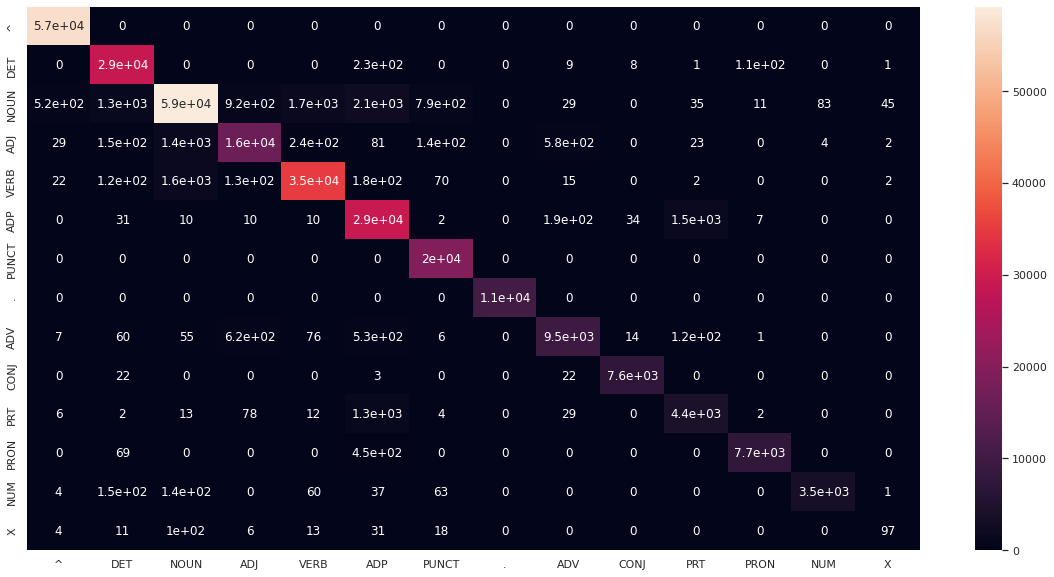

In [34]:
heat_map(metrics_1.conf_mat)

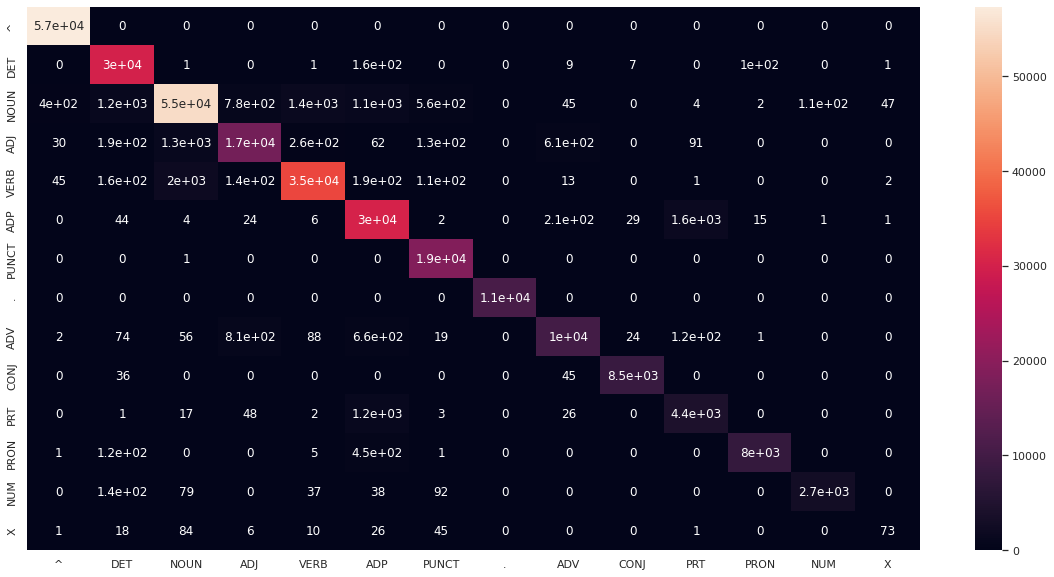

In [35]:
heat_map(metrics_2.conf_mat)

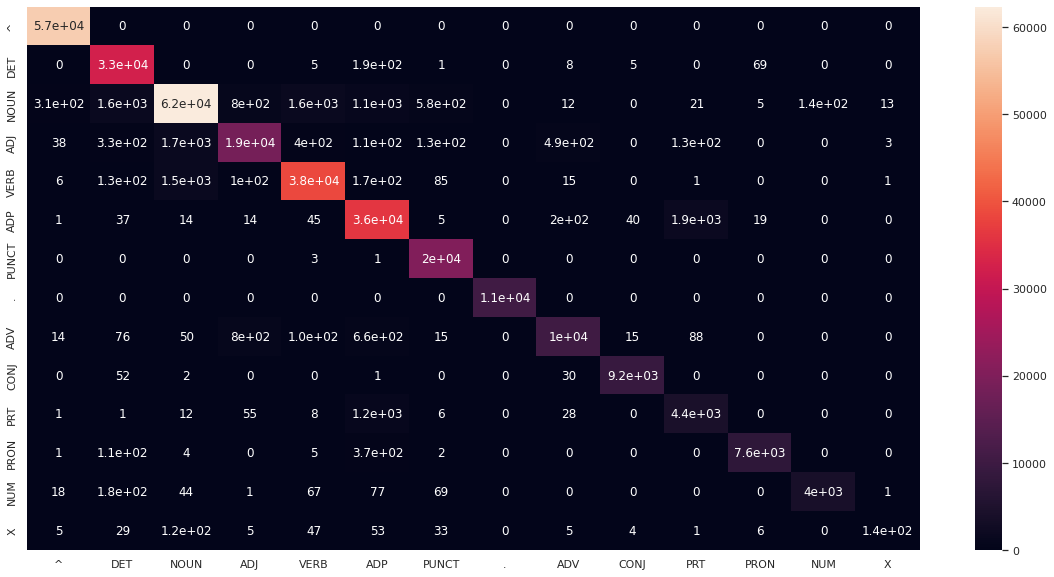

In [36]:
heat_map(metrics_3.conf_mat)

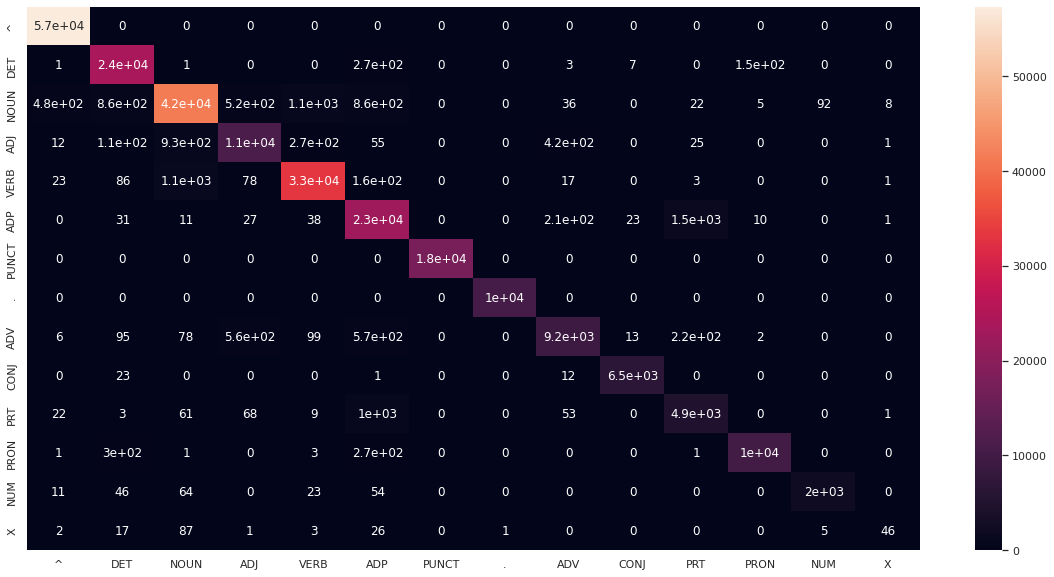

In [37]:
heat_map(metrics_4.conf_mat)

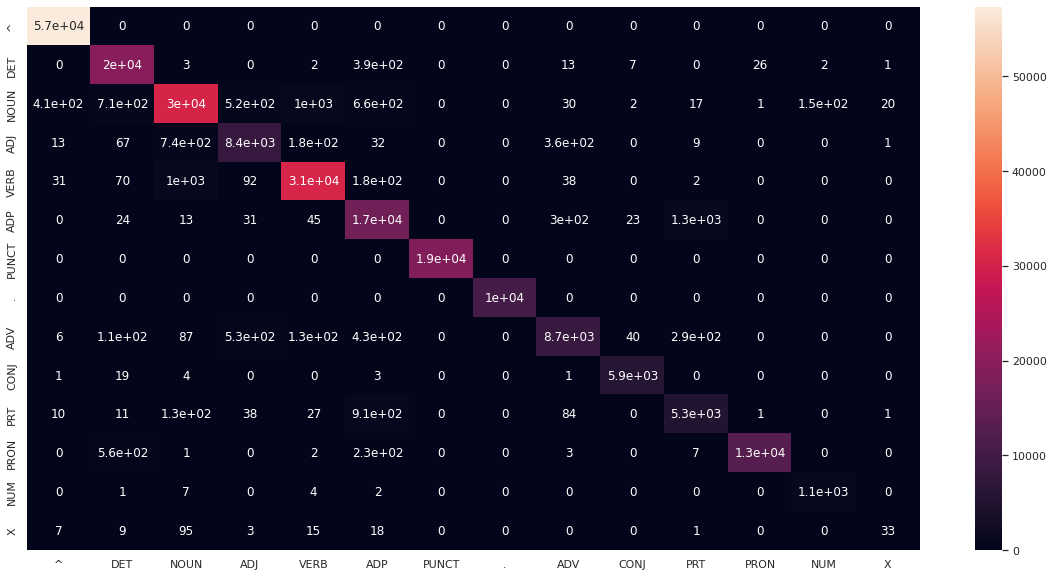

In [38]:
heat_map(metrics_5.conf_mat)

Average precision score is 0.9163853238635503
Average recall score is 0.8838909962926181
Average F1-score is 0.8925084275922511
Average F0.5-score is 0.9031995273136474
Average F2-score is 0.8864948630498735


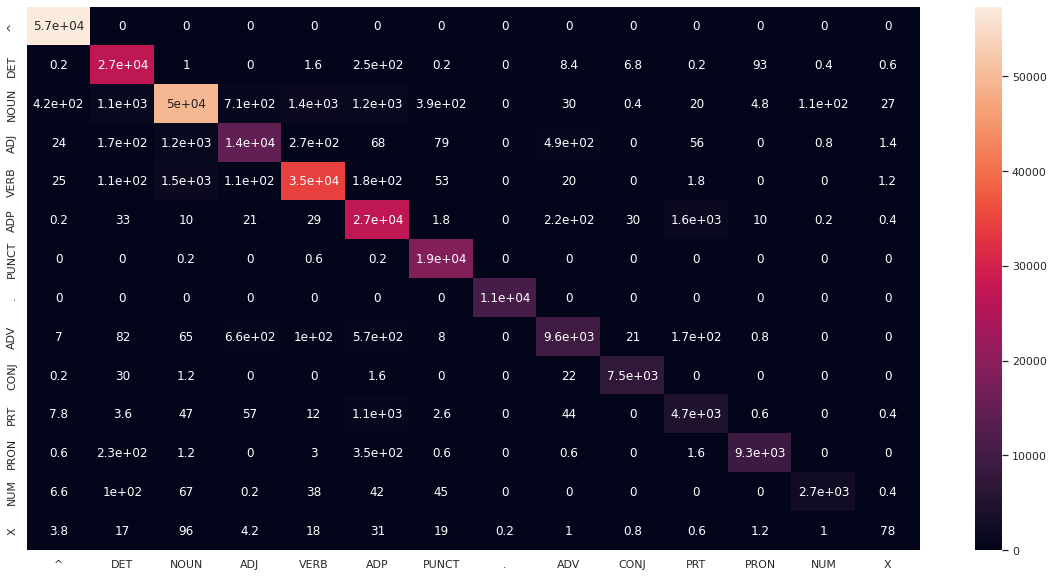

In [39]:
avg_conf_matrix = (( metrics_1.conf_mat + metrics_2.conf_mat + metrics_3.conf_mat + metrics_4.conf_mat + metrics_5.conf_mat)/5)
avg_prec = ((metrics_1.prec_score + metrics_2.prec_score + metrics_3.prec_score + metrics_4.prec_score + metrics_5.prec_score) / 5)
avg_rec = ((metrics_1.rec + metrics_2.rec + metrics_3.rec + metrics_4.rec + metrics_5.rec) / 5)
avg_f1_score = ((metrics_1.f1_score + metrics_2.f1_score + metrics_3.f1_score + metrics_4.f1_score + metrics_5.f1_score) / 5)
avg_f05_score = ((metrics_1.f05_score + metrics_2.f05_score + metrics_3.f05_score + metrics_4.f05_score + metrics_5.f05_score) / 5)
avg_f2_score = ((metrics_1.f2_score + metrics_2.f2_score + metrics_3.f2_score + metrics_4.f2_score + metrics_5.f2_score) / 5)
heat_map(avg_conf_matrix)
print(f'Average precision score is {mean(avg_prec)}')
print(f'Average recall score is {mean(avg_rec)}')
print(f'Average F1-score is {mean(avg_f1_score)}')
print(f'Average F0.5-score is {mean(avg_f05_score)}')
print(f'Average F2-score is {mean(avg_f2_score)}')

In [40]:
for i in range (0,len(avg_prec)):
    print(f'{unique_tag_labels[i]} : Precision score: {avg_prec[i]}, Recall : {avg_rec[i]}, F1 score: {avg_f1_score[i]}')

^ : Precision score: 0.9999808061420346, Recall : 1.0, F1 score: 0.99999040261049
DET : Precision score: 0.8990808694611703, Recall : 0.8585089163284738, F1 score: 0.8782683305402278
NOUN : Precision score: 0.8741508746530229, Recall : 0.9304784774976798, F1 score: 0.9013568937203381
ADJ : Precision score: 0.9191036358247201, Recall : 0.8500535794432571, F1 score: 0.8832044473114674
VERB : Precision score: 0.9920402498384856, Recall : 0.9930072385935655, F1 score: 0.9925203918798182
ADP : Precision score: 0.9335678966537125, Recall : 0.9859304180372078, F1 score: 0.959024258434499
PUNCT : Precision score: 0.9430104549167002, Recall : 0.9022310427957146, F1 score: 0.9221416902652466
. : Precision score: 0.9464801345453477, Recall : 0.9121128413212402, F1 score: 0.9274278912562245
ADV : Precision score: 0.9872388797874005, Recall : 0.939452309668097, F1 score: 0.9627417868364423
CONJ : Precision score: 0.7199666042427122, Recall : 0.7828364051425976, F1 score: 0.7498770969904746
PRT : Pr